# pyr-GC-MS Amino Acid Analysis

Notebook with code to replicate the analysis of pyr-GC-MS data.

## Import Packages

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import wilcoxon

## Unzip Mass Spec Data

In [2]:
!unzip /content/mass_spec_dataset.zip

Archive:  /content/mass_spec_dataset.zip
   creating: mass_spec_dataset/
  inflating: __MACOSX/._mass_spec_dataset  
   creating: mass_spec_dataset/Abiotic_reduced_simplified/
  inflating: __MACOSX/mass_spec_dataset/._Abiotic_reduced_simplified  
  inflating: mass_spec_dataset/.DS_Store  
  inflating: __MACOSX/mass_spec_dataset/._.DS_Store  
   creating: mass_spec_dataset/Biotic_reduced_simplified/
  inflating: __MACOSX/mass_spec_dataset/._Biotic_reduced_simplified  
  inflating: mass_spec_dataset/Abiotic_reduced_simplified/Lleu3d_cleaned_reduced_simplified.csv  
  inflating: __MACOSX/mass_spec_dataset/Abiotic_reduced_simplified/._Lleu3d_cleaned_reduced_simplified.csv  
  inflating: mass_spec_dataset/Abiotic_reduced_simplified/Cannak3d_cleaned_reduced_simplified.csv  
  inflating: __MACOSX/mass_spec_dataset/Abiotic_reduced_simplified/._Cannak3d_cleaned_reduced_simplified.csv  
  inflating: mass_spec_dataset/Abiotic_reduced_simplified/GlnMR3d_cleaned_reduced_simplified.csv  
  inflating

## Define Functions

In [33]:
def file_to_vectors(filename:str) -> np.array:
  """Converts a file contain mass spec data into a list representation
  of the vector representing the sample."""
  df = pd.read_csv(filename,index_col=None,header=0)
  max = np.max(df['Intensity'])
  df['Intensity'] = df['Intensity']/max
  return list(df['Intensity'])

def get_distance_matrix(X:np.array) -> np.array:
  """Generates an array containing the squared eculidean distance between each
  row in a matrix.
  """
  X1 = X[:, np.newaxis, :]
  X2 = X[np.newaxis, :, :]
  distances = np.sum((X1 - X2) ** 2, axis=2)
  return distances


def objective(alpha:np.array,distance_matrix:np.array) -> np.array:
  """Objective function for the optimal alpha value used in each anomalousness
  calculation.
  """
  mins = [np.min(d[d != 0]) for d in distance_matrix]
  avg_D = np.mean(mins)
  min_D = np.min(mins)
  sigma = -np.log(min_D / avg_D)/(avg_D**2 - min_D**2)
  sigma_sq_inv = 1 /(sigma**2)
  alpha_outer = np.outer(alpha,alpha)
  return np.sum(alpha_outer*np.exp(-distance_matrix * sigma_sq_inv))


def constraint(alpha:np.array):
  """Constraint used in the optimization process to findthe optimal alpha value
  used in each anomalousness calculation."""
  return np.sum(alpha)-1


def get_anoms(alpha:np.array,distance_matrix:np.array) -> np.array:
  """
  Returns an array containing the anomalousness of each sample in the set.

  Args:
    alpha: vector of alpha values obtained via optimization.
    distance_matrix: array containing the squared eculidean distance between
    the maximum intensity vectors for each sample.

  Returns:
    array containing the anomalousness of each sample in the set.
  """
  sigma = np.median(distance_matrix)
  sigma_sq_inv = 1 /(sigma**2)
  term1 = alpha*(-distance_matrix * sigma_sq_inv)
  alpha_outer = np.outer(alpha,alpha)
  term2 = alpha_outer*np.exp(-distance_matrix * sigma_sq_inv)
  return np.sum(1 - 2*term1 + term2,axis=1)


def ordinal_ranking(arr):
    """Return the ordinal ranking of each value in an array."""
    sorted_arr = sorted(set(arr))
    rank_map = {value: rank + 1 for rank, value in enumerate(sorted_arr)}
    return [(len(arr)+1)-rank_map[num] for num in arr]


def percentile_of_first(lst):
    """Return the percentile of the first element in a list."""
    if len(lst) < 2:
        raise ValueError("List must have at least two elements.")

    first = lst[0]
    rest = lst[1:]

    count = sum(x <= first for x in rest)
    percentile = (count / len(rest)) * 100

    return percentile

## Generate Figure 2

100%|██████████| 59/59 [00:00<00:00, 373.91it/s]


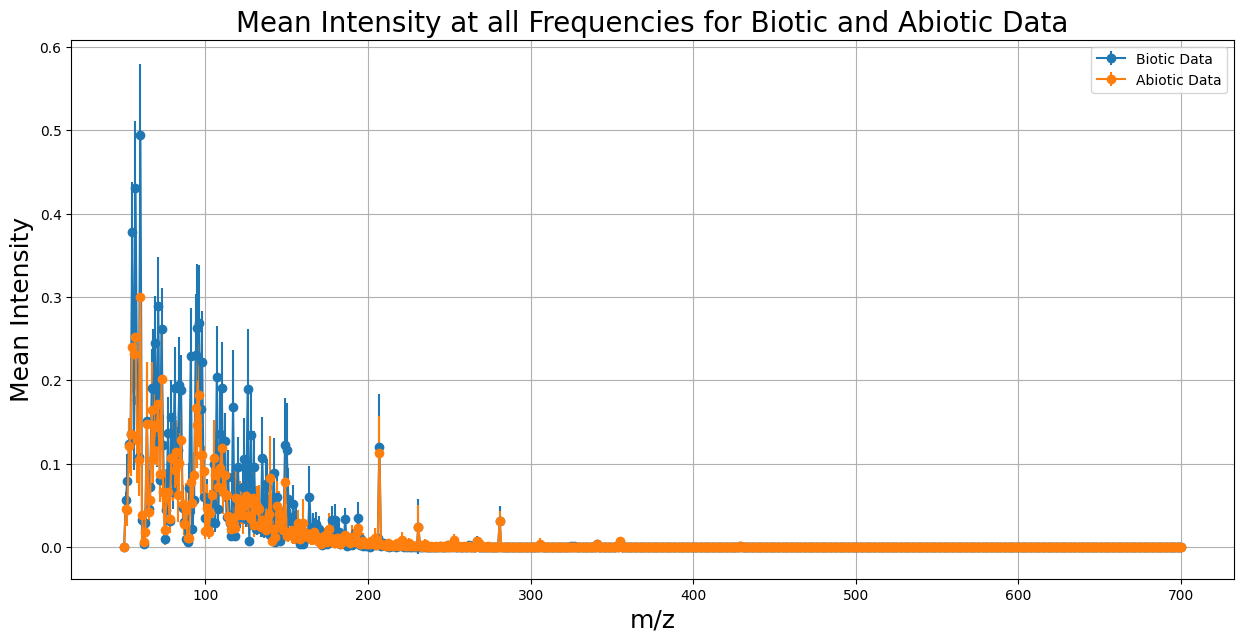

In [34]:
biotic_string = "/content/mass_spec_dataset/Biotic_reduced_simplified/*.csv"
abiotic_string = "/content/mass_spec_dataset/Abiotic_reduced_simplified/*.csv"
biotic_filenames = glob.glob(os.path.join(biotic_string))
abiotic_filenames = glob.glob(os.path.join(abiotic_string))

#Create array of abiotic data.
abiotic_data = []
for name in tqdm(abiotic_filenames):
  abiotic_data.append(file_to_vectors(name))
abiotic_data = np.array(abiotic_data)

#Create array of biotic data.
biotic_data = []
for name in tqdm(biotic_filenames):
  biotic_data.append(file_to_vectors(name))
biotic_data = np.array(biotic_data)


# Calculate mean and confidence intervals for biotic data
biotic_means = np.mean(biotic_data, axis=0)
biotic_std = np.std(biotic_data, axis=0)
biotic_ci = 1.96 * (biotic_std / np.sqrt(biotic_data.shape[0]))

# Calculate mean and confidence intervals for abiotic data
abiotic_means = np.mean(abiotic_data, axis=0)
abiotic_std = np.std(abiotic_data, axis=0)
abiotic_ci = 1.96 * (abiotic_std / np.sqrt(abiotic_data.shape[0]))

# Create a plot
plt.figure(figsize=(15, 7))
plt.errorbar(range(50,701), biotic_means, yerr=biotic_ci,
             label='Biotic Data', fmt='-o')
plt.errorbar(range(50,701), abiotic_means, yerr=abiotic_ci,
             label='Abiotic Data', fmt='-o')

plt.xlabel('m/z',fontsize=18)
plt.ylabel('Mean Intensity',fontsize=18)
plt.title('Mean Intensity at all Frequencies for Biotic and Abiotic Data',
          fontsize=20)
plt.legend()
plt.grid(True)
plt.savefig('mean_intensity.png')
plt.show()

In [35]:
prefix = "/content/mass_spec_dataset/Biotic_reduced_simplified"
data = []
for name in tqdm(biotic_filenames):  #Loop through all biotic sample files.
  biotic_data = file_to_vectors(name)#Convert biotic sample file to vector form.
  all_data = np.vstack((biotic_data, abiotic_data)) #Append biotic sample vector
                                                    #to abiotic dataset.
  D = get_distance_matrix(all_data)  #Generate distance matrix for all samples.

  #Find optimal alphas using constrained optimization.
  b = (0,1)
  bnds = [b for i in range(len(all_data))]
  con1 = {'type': 'eq', 'fun': constraint}
  cons = [con1]
  alpha0 = np.zeros(len(all_data))

  solution = minimize(objective, alpha0, method='SLSQP', bounds=bnds,
                      args=(D), constraints=cons)
  alpha = solution.x

  #Calculate anomalousness of each sample relative to the abiotic set.
  anoms = get_anoms(alpha, D)

  #Append results for this biotic sample.
  data.append({
      "Biotic Sample": name.replace(prefix, ""),  #Clean sample name.
      "Anomalousness Ranking for Biotic Sample (out of 70)":
          ordinal_ranking(anoms)[0],
      "Anomalousness of Biotic Sample": anoms[0],
      "Median Anomalousness of Abiotic Samples": np.median(anoms[1:]),
      "Anomalousness Percentile of Biotic Sample": percentile_of_first(anoms)
  })

#Save results as a dataframe and to CSV.
results_df = pd.DataFrame(data)
results_df.to_csv("anomalousness_results.csv")

#Wilcoxon test of whether biotic anomalousness percentiles differ from 50.
stat, p_value = wilcoxon([p - 50 for p in
                      results_df['Anomalousness Percentile of Biotic Sample']])

print(f"Wilcoxon statistic: {stat}, p-value: {p_value:.4f}")


100%|██████████| 59/59 [01:30<00:00,  1.53s/it]

Wilcoxon statistic: 622.0, p-value: 0.0471


## Generate Figure 5

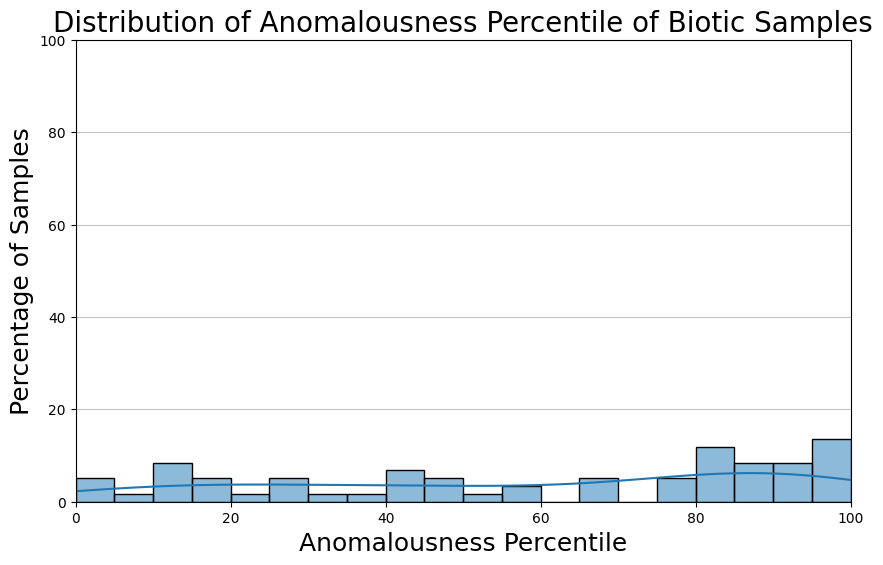

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Anomalousness Percentile of Biotic Sample',
             stat="percent", kde=True, bins=20)
plt.title('Distribution of Anomalousness Percentile of Biotic Samples',
          fontsize=20)
plt.xlabel('Anomalousness Percentile',fontsize=18)
plt.ylabel('Percentage of Samples',fontsize=18)
plt.xlim(0, 100)   # adjust as desired
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.75)
plt.savefig("mass_spec_percentile_comparison.png", dpi=300)
plt.show()